In [1]:
import PSILOGIT
import numpy as np
from PSILOGIT.tools import *
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt

def linear_temperature(t):
    return 0.2/np.log(t+1)

# Run only one cell below depending on the setting you want to use

In [19]:
################### SETTING 1 Localized
nu = 0.4

n,p = 100,10

## CHOOSE THE MODE (LOCALIZED OR DISSEMINATED)
modes = ['disseminated-signal' ,'localized-signal']
mode = modes[1]

## CHOOSE THE NUMBER OF STEP FOR THE REJECTION SAMPLING METHOD 
nb_ite = 10000 # 400000

lamb = 5

if mode=='localized-signal':
    vartheta = np.zeros(p)
    vartheta[0] = nu
else:
    vartheta = nu*np.ones(p)
    

model = PSILOGIT.PSILOGIT(truetheta=vartheta, regularization=1/lamb, n=n, p=p)
print('Size of the set of active variables: ', len(model.M))
model.sampling_algorithm = 'RS'

Size of the set of active variables:  9


In [3]:
################### SETTING 2 Localized
nu = 3

n,p = 20, 15

## CHOOSE THE MODE (LOCALIZED OR DISSEMINATED)
modes = ['disseminated-signal' ,'localized-signal']
mode = modes[1]

## CHOOSE THE NUMBER OF STEP FOR THE REJECTION SAMPLING METHOD 
nb_ite = 10000 # 400000

lamb = 3

if mode=='localized-signal':
    vartheta = np.zeros(p)
    vartheta[0] = nu
else:
    vartheta = nu*np.ones(p)
    

model = PSILOGIT.PSILOGIT(truetheta=vartheta, regularization=1/lamb, n=n, p=p)
print('Size of the set of active variables: ', len(model.M))
model.sampling_algorithm = 'SA'

Size of the set of active variables:  5


In [14]:
################### SETTING 3 Localized
nu = 3

n,p = 20, 30

## CHOOSE THE MODE (LOCALIZED OR DISSEMINATED)
modes = ['disseminated-signal' ,'localized-signal']
mode = modes[1]

## CHOOSE THE NUMBER OF STEP FOR THE REJECTION SAMPLING METHOD 
nb_ite = 10000 # 400000

lamb = 3

if mode=='localized-signal':
    vartheta = np.zeros(p)
    vartheta[0] = nu
else:
    vartheta = nu*np.ones(p)
    
    
model = PSILOGIT.PSILOGIT(truetheta=vartheta, regularization=1/lamb, n=n, p=p)
print('Size of the set of active variables: ', len(model.M))
model.sampling_algorithm = 'SA'

Size of the set of active variables:  11


# Sampling states

In [20]:
thetanull = np.zeros(model.X.shape[1])
signull = sigmoid(model.X @ thetanull)
if model.sampling_algorithm !='SA':
    states = model.SEI_by_sampling(model.sig, nb_ite=nb_ite)
    if np.max(np.abs(signull-model.sig))<1e-3:
        statesnull = np.copy(states)
    else:
        statesnull = model.SEI_by_sampling(signull, nb_ite=nb_ite)
else:
    states, ls_FNR, energies = model.SEI_SLR(total_length_SEISLR_path=50000, backup_start_time=2000, temperature=linear_temperature, repulsing_force=True, random_start=True, conditioning_signs=False, seed=0)
    if np.max(np.abs(signull-model.sig))<1e-3:
        statesnull = np.copy(states)
    else:
        statesnull, ls_FNR, energies = model.SEI_SLR(total_length_SEISLR_path=50000, backup_start_time=2000, temperature=linear_temperature, repulsing_force=True, random_start=True, conditioning_signs=False, seed=0)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

# Computing covariance matrices and centering parameters

In [21]:
##### COMPUTING COVARIANCE MATRICES
n,p = (model.X).shape
matXtrue = model.X[:,model.M]

tildeGN12, barpi = model.params_saturated(signull, statesnull)
tildetheta, gaps = model.compute_theta_bar(barpi, grad_descent={'lr':0.01,'return_gaps':True,'max_ite':10000})
GN = matXtrue.T @ np.diag(barpi*(np.ones(n)-barpi)) @ matXtrue
HN = matXtrue.T @ np.diag(sigmoid1(matXtrue @ tildetheta)) @ matXtrue


if model.sampling_algorithm != 'SA':
    # Linear conditional covariance statistic (SATURATED)
    Gammabar = np.zeros((n,n))
    for y in statesnull:
        Gammabar += np.reshape(y-barpi, (-1,1)) @ np.reshape(y-barpi, (1,-1)) / len(statesnull)
    usvd,s,vt = np.linalg.svd(Gammabar)
    Gammabar_12 = usvd @ np.diag(1/np.sqrt(s)) @ vt
else:
    # Linear conditional covariance statistic (SATURATED)
    Gammabar = np.zeros((n,n))
    normalization = 0
    for y in statesnull:
        proba = compute_proba(y,signull)
        Gammabar += np.reshape(y-barpi, (-1,1)) @ np.reshape(y-barpi, (1,-1)) * proba
        normalization += proba
    Gammabar /= normalization
    usvd,s,vt = np.linalg.svd(Gammabar)
    Gammabar_12 = usvd @ np.diag(1/np.sqrt(s)) @ vt

# Linear unconditional covariance statistic (SATURATED)
Gamma = np.diag(signull *(np.ones(n)-signull))
usvd,s,vt = np.linalg.svd(Gamma)
Gamma_12 = usvd @ np.diag(1/np.sqrt(s)) @ vt


# SIGLE (SELECTED)
usvd,s,vt = np.linalg.svd(GN)
GN_12 = usvd @ np.diag(1/np.sqrt(s)) @ vt
VN = GN_12 @ HN

# Logistic unconditional Fisher statistic (SELECTED)
HN_uncondi = matXtrue.T @ np.diag(sigmoid1(model.X @ vartheta)) @ matXtrue
GN_uncondi = matXtrue.T @ Gamma @ matXtrue
usvd,s,vt = np.linalg.svd(GN_uncondi)
GN_uncondi_12 = usvd @ np.diag(1/np.sqrt(s)) @ vt
VN_fisher = GN_uncondi_12 @ HN_uncondi

# SIGLE correlated (SELECTED)
GNbar_misspe = matXtrue.T @ Gammabar @ matXtrue
usvd,s,vt = np.linalg.svd(GNbar_misspe)
GNbar_misspe_12 = usvd @ np.diag(1/np.sqrt(s)) @ vt
VN_misspe = GNbar_misspe_12 @ HN
    
covariances = {'saturated' : {'SIGLE'        : GN_12 @ matXtrue.T,
                              'SIGLE correlated': GNbar_misspe_12 @ matXtrue.T,
                              'Logistic unconditional Fisher statistic':  GN_uncondi_12 @ matXtrue.T,
                              'Linear conditional covariance statistic'  : Gammabar_12,
                              'Linear unconditional covariance statistic': Gamma_12
                             },
               'selected'  : {'SIGLE'        : VN,
                              'SIGLE correlated': VN_misspe ,
                              'Logistic unconditional Fisher statistic' :  VN_fisher
                              }
              }
centers =     {'saturated' : {'SIGLE'        : barpi,
                              'SIGLE correlated': barpi,
                              'Logistic unconditional Fisher statistic' : signull,
                              'Linear conditional covariance statistic'  : barpi,
                              'Linear unconditional covariance statistic': signull
                             },
               'selected'  : {'SIGLE'  : tildetheta,
                              'SIGLE correlated': tildetheta,
                              'Logistic unconditional Fisher statistic':  thetanull[model.M]
                             }
              }

  0%|          | 0/228 [00:00<?, ?it/s]

# Saturated model

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

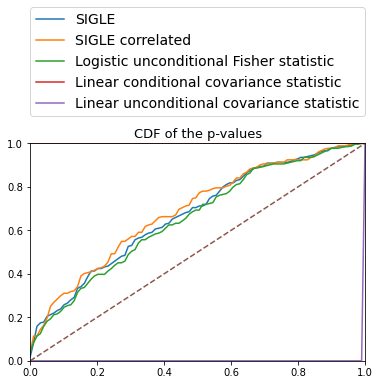

In [22]:
ls_modes_sat = [key for key in covariances['saturated'].keys()]

lists_pvalues_sat = []
for mode in ls_modes_sat:
    center_sat = centers['saturated'][mode]
    cov_sat = covariances['saturated'][mode]
    lspvals_sat = model.pval_alt_SIGLE_sat(states, center_sat, cov_sat, l2_regularization=100000, statesnull=statesnull, signull=signull)
    lists_pvalues_sat += [lspvals_sat]

model.plot_cdf_pvalues(lists_pvalues_sat, ls_modes_sat, states = states, legend_outfig=True, sigalt=model.sig)

# Selected model

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

  0%|          | 0/264 [00:00<?, ?it/s]

  0%|          | 0/228 [00:00<?, ?it/s]

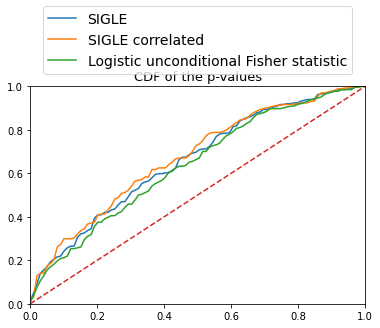

In [23]:
ls_modes_sel = [key for key in covariances['selected'].keys()]

lists_pvalues_sel = []
for mode in ls_modes_sel:
    center_sel = centers['selected'][mode]
    cov_sel = covariances['selected'][mode]
    lspvals_sel = model.pval_alt_SIGLE_sel(states, center_sel, cov_sel, l2_regularization=100000, statesnull=statesnull, signull=signull)
    lists_pvalues_sel += [lspvals_sel]

model.plot_cdf_pvalues(lists_pvalues_sel, ls_modes_sel, states = states, legend_outfig=True, sigalt=model.sig)

# Comparison with the $\chi^2$ distribution

/tmp/ipykernel_11480/1037124601.py:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mini = np.float('inf')


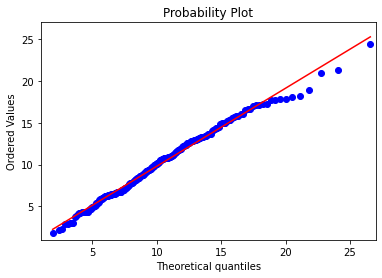

In [24]:
import numpy as np
import pylab
import scipy.stats as stats
mode = 'SIGLE'
center_sat = centers['saturated'][mode]
cov_sat = covariances['saturated'][mode]

lsstatnull_sat = []
for i in range(len(statesnull)):
    y = np.array(statesnull[i])
    stat = np.linalg.norm( cov_sat @ (y-center_sat))**2
    lsstatnull_sat.append(stat)

mini = np.float('inf')
optdf = 0
for df in np.arange(2,50,1):
    qq = stats.probplot(lsstatnull_sat, dist=stats.chi2, sparams=(df,))
    norm = np.linalg.norm(qq[0][0]-qq[0][1])
    if norm<mini:
        optdf = df
        mini = norm


fig = plt.figure()
ax = fig.add_subplot(111)
#df = np.mean(lsstatnull_sat) #len(model.M)
#print(df, model.M)
qq = stats.probplot(lsstatnull_sat, dist=stats.chi2, sparams=(optdf,), plot=ax)
#plt.axis('square')
ax.set_xlim([1, 27])
ax.set_ylim([1, 27])

#plt.savefig('quantiles_sat_'+mode+'.png', dpi=250)
plt.show()

/home/duchemin/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/duchemin/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


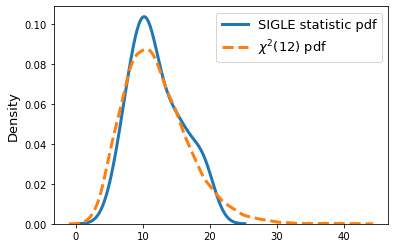

In [11]:
import seaborn as sns
sns.distplot(lsstatnull_sat, hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = 'SIGLE statistic pdf')
chi2 = stats.chi2.rvs(optdf, size=10000)
sns.distplot(chi2, hist = False, kde = True,
                 kde_kws = {'linewidth': 3, 'linestyle':'--'},
                 label = '$\chi^2({0})$ pdf'.format(optdf))
plt.legend(fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.savefig('PDFs_sigle_vs_chi2_nu04.png', dpi=250)